In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import wandb

In [2]:
wandb.login(key='288db8f5afccc57f269ae50ac116d15047b1b705')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mitanshkayathwal (mmavericks). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/mitanshk/.netrc


True

In [3]:
df = pd.read_csv("WineQT.csv")
df.drop('Id',axis=1,inplace=True)
df.head()

X = df.drop(columns=['quality'])
y = df['quality']

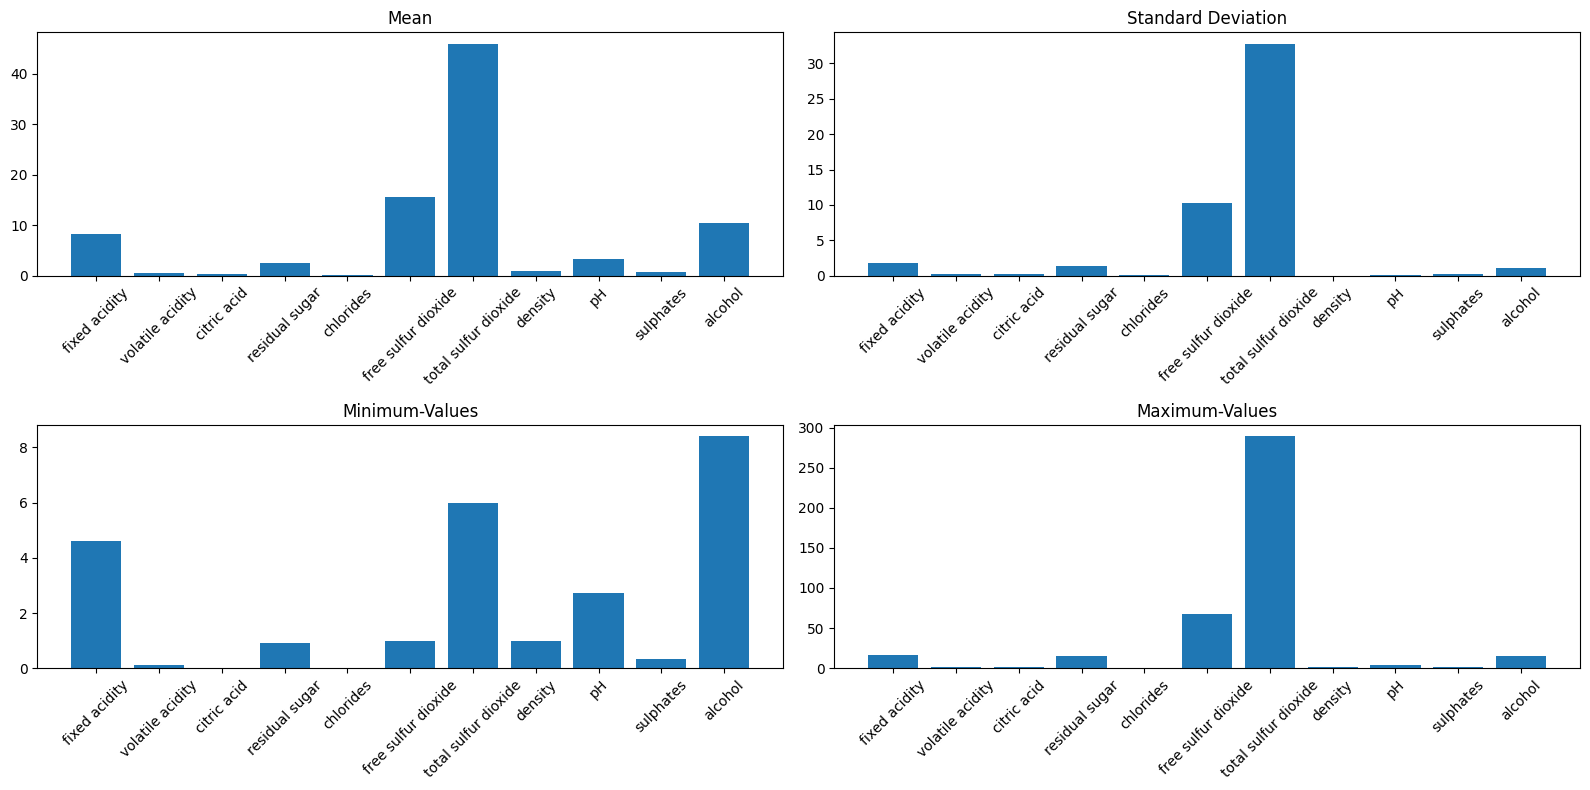

In [4]:
means = np.mean(X, axis=0)
std_devs = np.std(X, axis=0)
min_values = np.min(X, axis=0)
max_values = np.max(X, axis=0)
attribute_labels = X.columns.tolist()

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

axs[0, 0].bar(attribute_labels, means)
axs[0, 0].set_title('Mean')

axs[0, 1].bar(attribute_labels, std_devs)
axs[0, 1].set_title('Standard Deviation')

axs[1, 0].bar(attribute_labels, min_values)
axs[1, 0].set_title('Minimum-Values')

axs[1, 1].bar(attribute_labels, max_values)
axs[1, 1].set_title('Maximum-Values')

for ax in axs.flat:
    ax.set_xticks(range(len(attribute_labels)))
    ax.set_xticklabels(attribute_labels, rotation=45)

plt.tight_layout()
plt.show()

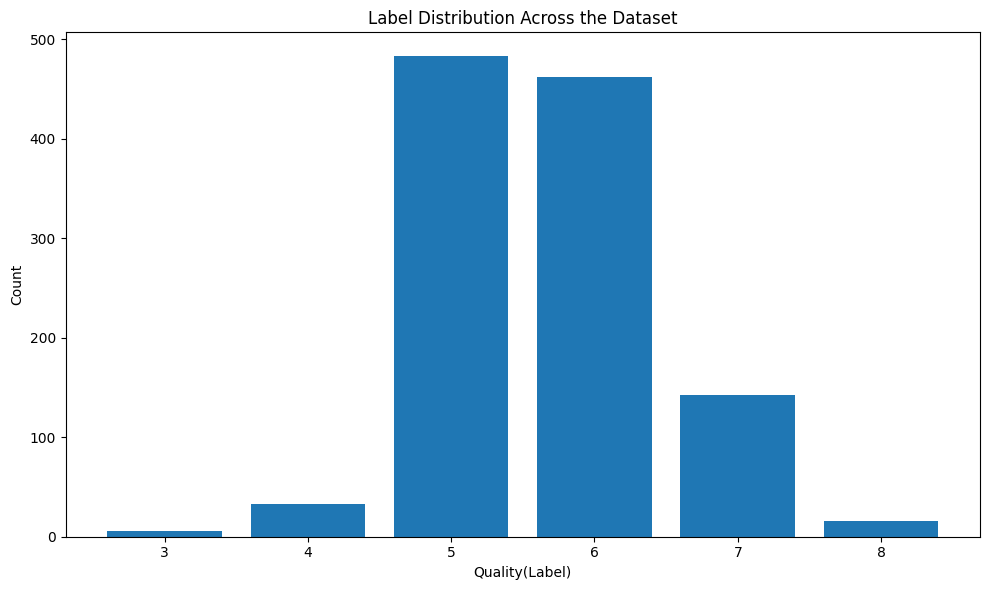

In [5]:
label_counts = df['quality'].value_counts()
unique_labels = label_counts.index

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)

plt.xlabel('Quality(Label)')
plt.ylabel('Count')
plt.title('Label Distribution Across the Dataset')

plt.tight_layout()
plt.show()

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [7]:
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_val.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

std_scaler = StandardScaler()  
X_train_final = std_scaler.fit_transform(X_train)
X_val_final = std_scaler.transform(X_val)
X_test_final = std_scaler.transform(X_test)

In [11]:
class MultiClassRegression:
    def __init__(self, X, y_true):
        self.X = X    
        self.y_true = y_true
    
    def one_hot_encode(self, y):
        max_label_num = 6
        one_hot_matrix = np.zeros((len(y), max_label_num))
        one_hot_matrix[np.arange(len(y)), np.array(y) - 3] = 1
        
        return one_hot_matrix

    def fit(self, learning_rate = 0.01, epochs = 2000):
        self.y_true = self.one_hot_encode(self.y_true)
        self.weights, self.bias = self.gradient_descent(learning_rate, epochs)

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        return -np.mean(y_true * np.log(y_pred + epsilon))
    
    def accuracy_reg(self, y_true, y_pred):
        num_correct = np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))
        return num_correct / y_true.shape[0]

    def evaluate_loss(self, X, y):
        y_pred = np.argmax(self.predict(X),axis=1)+3
        return self.cross_entropy_loss(y, y_pred)

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return y_pred

    def gradient_descent(self, learning_rate=1e-2, num_iterations=2000):
        num_samples, num_features = self.X.shape
        num_classes = self.y_true.shape[1]
        
        weights = np.zeros((num_features, num_classes))
        bias = np.zeros(num_classes)
        for i in range(num_iterations):
            z = np.dot(self.X, weights) + bias
            y_pred = self.softmax(z)
            gradient = np.dot(self.X.T, (y_pred - self.y_true)) / num_samples
            weights -= learning_rate * gradient
            bias -= learning_rate * np.sum(y_pred - self.y_true,axis=0) / num_samples
            loss = self.cross_entropy_loss(self.y_true, y_pred)
        return weights, bias

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def evaluate_accuracy(self, X, y):
        y_pred = np.argmax(self.predict(X),axis=1)+3
        return accuracy_score(y, y_pred)

    def evaluate_metrics(self, X, y):
        y_pred = np.argmax(self.predict(X),axis=1)+3
        return classification_report(y, y_pred,zero_division=1)

In [12]:
multi_reg = MultiClassRegression(X_train_final, y_train)
multi_reg.fit()

report = multi_reg.evaluate_metrics(X_train_final,y_train)

print("sklearn Classification Report on Train Dataset:")
print()
print(report)

sklearn Classification Report on Train Dataset:

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        21
           5       0.69      0.79      0.74       324
           6       0.56      0.64      0.60       283
           7       0.55      0.20      0.29        90
           8       1.00      0.00      0.00         9

    accuracy                           0.63       731
   macro avg       0.80      0.27      0.27       731
weighted avg       0.64      0.63      0.59       731



In [13]:
epochs = [500, 1000, 2000, 5000]
learning_rates = [0.001, 0.01, 0.1]

best_hyperparams = None
best_accuracy = 0
report = None

for num_iter in epochs:
    for lr in learning_rates:
        run = wandb.init(
            project="SMAI_As3_Q1", entity="mitanshkayathwal"
        )
        multi_reg = MultiClassRegression(X_val_final, y_val)
        multi_reg.fit(lr, num_iter)
        acc = multi_reg.evaluate_accuracy(X_val_final, y_val)
        loss = multi_reg.evaluate_loss(X_val_final, y_val)
        wandb.log({"Epochs": num_iter,
                   "Learning Rate":lr,
                   "Accuracy": acc,
                   "Loss": loss})
        if(acc>best_accuracy):
            best_hyperparams = [num_iter, lr]
            best_accuracy = acc
            report = multi_reg.evaluate_metrics(X_val_final, y_val)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.56284
Epochs,500
Learning Rate,0.001
Loss,-10.10545


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.57923
Epochs,500
Learning Rate,0.01
Loss,-10.10165


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.62295
Epochs,500
Learning Rate,0.1
Loss,-10.11235


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.56284
Epochs,1000
Learning Rate,0.001
Loss,-10.10545


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.60109
Epochs,1000
Learning Rate,0.01
Loss,-10.1294


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.63934
Epochs,1000
Learning Rate,0.1
Loss,-10.10769


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.5847
Epochs,2000
Learning Rate,0.001
Loss,-10.09634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.61202
Epochs,2000
Learning Rate,0.01
Loss,-10.13716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.63934
Epochs,2000
Learning Rate,0.1
Loss,-10.0846


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.57923
Epochs,5000
Learning Rate,0.001
Loss,-10.10165


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Epochs,▁
Learning Rate,▁
Loss,▁
Accuracy,0.62295
Epochs,5000
Learning Rate,0.01
Loss,-10.11235


In [14]:
print("Best Hyper-parameters are: ")
print()
print("Epochs: " + str(best_hyperparams[0]))
print("Learning Rate: " + str(best_hyperparams[1]))
print()
print("Classification report on Validation set on best Hyper-parameters is: ")
print()
print(report)

Best Hyper-parameters are: 

Epochs: 5000
Learning Rate: 0.1

Classification report on Validation set on best Hyper-parameters is: 

              precision    recall  f1-score   support

           3       0.50      0.50      0.50         2
           4       1.00      0.83      0.91         6
           5       0.66      0.70      0.68        63
           6       0.63      0.61      0.62        80
           7       0.61      0.63      0.62        27
           8       1.00      0.60      0.75         5

    accuracy                           0.65       183
   macro avg       0.73      0.65      0.68       183
weighted avg       0.66      0.65      0.65       183



In [15]:
multi_reg = MultiClassRegression(X_train_final, y_train)
multi_reg.fit()

report = multi_reg.evaluate_metrics(X_test_final,y_test)

print("sklearn Classification Report on Test Dataset:")
print()
print(report)

sklearn Classification Report on Test Dataset:

              precision    recall  f1-score   support

           4       1.00      0.00      0.00         6
           5       0.68      0.74      0.71        96
           6       0.62      0.70      0.65        99
           7       0.67      0.31      0.42        26
           8       1.00      0.00      0.00         2

    accuracy                           0.65       229
   macro avg       0.79      0.35      0.36       229
weighted avg       0.66      0.65      0.63       229



wandb: Network error (ConnectTimeout), entering retry loop.
